In progress... work, there will be quite a number of grammatical errors and some things will be incomplete

# Example 1; the flow of deepSI

basic introduction and terminology. 


u -> System -> y

System_data = [u,y]


example 1: Basics

* Creating datasets and the .u and .y attributes
* Linear SYSID
* Simulating datasets
* Evaluation, NRMS, and plotting (test - test_p)
* SS_encoder
* saving and loading systems

## 1. Create measurement data

$$
x_{k+1}^{(0)} = \frac{x_k^{(0)}}{1.2 + \left(x_k^{(1)}\right)^2} + 0.4 x_k^{(1)}\\
x_{k+1}^{(1)} = \frac{x_k^{(1)}}{1.2 + \left(x_k^{(0)}\right)^2} + 0.4 x_k^{(0)} + u_k \left (1 + 0.1\left (x_k^{(0)} \right )^2 \right )\\
y_k = 0.1 x_k^{(1)} x_k^{(0)} + x_k^{(0)}
$$ 

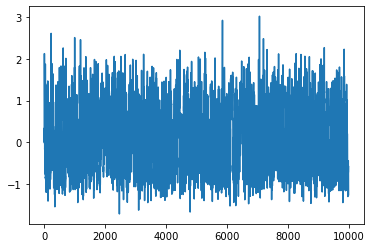

u [ 3.44448476e-01  3.34113101e-01 -3.92105884e-01 -7.71707226e-01
  4.11430817e-01  2.10144343e+00  1.95625795e+00  9.57893833e-01
  1.39140432e+00  9.60847837e-04]
y [0.         0.         0.14633761 0.34110502 0.32387615 0.02730107
 0.10590796 1.26415681 2.12515433 1.92545925]


In [1]:
import numpy as np
N = 10_000
ulist = np.random.normal(size=N) #input sequence
ylist = []
x = [0,0]
for uk in ulist:
    yk = x[1]*x[0]*0.1 + x[0]
    ylist.append(yk)
    x = x[0]/(1.2+x[1]**2) + x[1]*0.4, x[1]/(1.2+x[0]**2)+x[0]*0.4+uk*(1+x[0]**2/10)

    
ylist = np.array(ylist)
#show results
from  matplotlib import pyplot as plt
plt.plot(ylist)
plt.show()

print('u',ulist[:10])
print('y',ylist[:10])

Put the system data in the `System_data` format to be processed by deepSI and split data set into train and test

System_data of length: 10000 nu=None ny=None normed=False dt=None


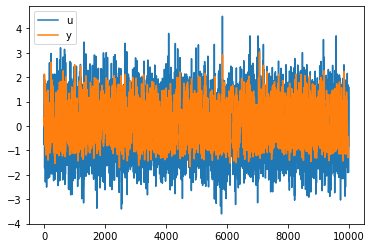

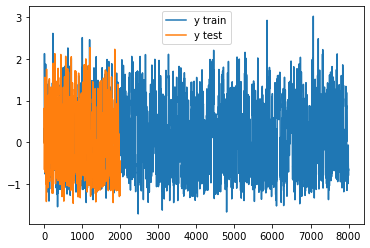

In [2]:
import deepSI
from deepSI import System_data
system_data = System_data(u=ulist,y=ylist)
print(system_data) #contains both the input and the output
plt.plot(system_data.u) #system_data.y contains the output array of length N
plt.plot(system_data.y) #system_data.u contains the input  array of length N
plt.legend(['u','y'])
plt.show()

train, test = system_data[:8000], system_data[8000:] #slice the datatset in two (or use system_data.train_test_split(split_fraction=0.2))
plt.plot(train.y,label='y train')
plt.plot(test.y,label='y test')
plt.legend()
plt.show()

## 2. Estimate a BLA ARX and linear state-space model



In [3]:
fit_sys_SS = deepSI.fit_systems.SS_linear(nx=3) #SS_f = 8
fit_sys_IO = deepSI.fit_systems.Sklearn_io_linear(na=2,nb=2)

fit_sys_SS.fit(train, SS_f = 8)
print(f'SS \tA={fit_sys_SS.A} \n \t B={fit_sys_SS.B}\n\t C={fit_sys_SS.C}') #parameters

fit_sys_IO.fit(train)
print(f'ARX paramters: [A,B] = {fit_sys_IO.reg.coef_} offset={fit_sys_IO.reg.intercept_}')  #parameters


SS 	A=[[ 9.01209522e-01  1.06121047e-01 -4.57038033e-05]
 [-3.64208930e-01  1.53172972e-01  5.52871352e-03]
 [-3.64625101e-01 -6.69589352e-01  5.49380779e-01]] 
 	 B=[[-0.40727114]
 [-0.92059048]
 [-0.0870871 ]]
	 C=[[-8.45719513e-01  3.68131463e-01 -5.44839856e-04]]
ARX paramters: [A,B] = [ 0.38885442  0.00493788 -0.13595048  1.00783371] offset=-1.913376327689058e-05


## 3. Running simulation using fitted systems

RMS simulation SS linear 0.36
RMS simulation IO linear 0.36
NRMS simulation SS linear 46.15%
NRMS simulation IO linear 46.36%


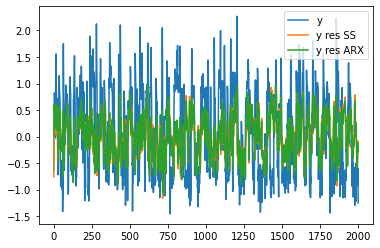

In [4]:
# uses a free run simulation from the appropriate initial state 
# (see docs for details: https://deepsi.readthedocs.io/en/latest/systems.html#deepSI.systems.System.apply_experiment)
test_sim_SS = fit_sys_SS.apply_experiment(test)
test_sim_IO = fit_sys_IO.apply_experiment(test) 

#calculate errors errors
print(f'RMS simulation SS linear {test_sim_SS.RMS(test):.2}') #equivilent to np.mean((test_sim_SS.y - test.y)**2)**0.5
print(f'RMS simulation IO linear {test_sim_IO.RMS(test):.2}') #equivilent to np.mean((test_sim_IO.y[2:] - test.y[2:])**2)**0.5

print(f'NRMS simulation SS linear {test_sim_SS.NRMS(test):.2%}') #equivilent to np.mean((test_sim_SS.y - test.y)**2)**0.5/np.std(test.y)
print(f'NRMS simulation IO linear {test_sim_IO.NRMS(test):.2%}') #equivilent to np.mean((test_sim_IO.y[2:] - test.y[2:])**2)**0.5/np.std(test.y)

plt.plot(test.y)
plt.plot(test.y - test_sim_SS.y)
plt.plot(test.y - test_sim_IO.y)
plt.legend(['y','y res SS','y res ARX'])
plt.show()

## 4. SS encoder approach

The SS encoder (https://arxiv.org/abs/2012.07697) is a versatile method for many non-linear estimation problems.

**Causion!** Optimization might take very long, one might use a KeyboardInterrupt (Ctrl-C on command lines) to cut the optimization short.

**Causion** Using a if `__name__=='__main__'` is essential for good opperation in scripts. (XXX link)

In [5]:
fit_sys_ss_enc = deepSI.fit_systems.SS_encoder(nx=6, na=3, nb=3) #state dimention = 6, past outputs = 3, past inputs = 3.
train_enc, val_enc = train.train_test_split(split_fraction=0.25)

#Start fitting
fit_sys_ss_enc.fit(train_enc, sim_val=val_enc, epochs=100, batch_size=256, loss_kwargs={'nf':50}) #nf is T in paper

Size of the training array =  4.8 MB
N_training_samples = 5948, batch_size = 256, N_batch_updates_per_epoch = 23
Initial Validation NRMS= 1.1065284994013724


  0%|          | 0/100 [00:00<?, ?it/s]

########## New lowest validation loss achieved ########### NRMS = 0.5183092334517143
Epoch    1, sqrt loss  0.9018, Val NRMS 0.5183, Time Loss: 76.0%, data: 0.2%, val: 23.8%, 15.2 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.3230713597932648
Epoch    2, sqrt loss   0.406, Val NRMS 0.3231, Time Loss: 75.2%, data: 0.3%, val: 24.5%, 15.9 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.2670763889234242
Epoch    3, sqrt loss  0.2902, Val NRMS 0.2671, Time Loss: 75.4%, data: 0.3%, val: 24.2%, 15.6 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.23209782132515525
Epoch    4, sqrt loss  0.2474, Val NRMS 0.2321, Time Loss: 75.2%, data: 0.3%, val: 24.5%, 15.8 batches/sec
Epoch    5, sqrt loss  0.2238, Val NRMS  0.243, Time Loss: 75.3%, data: 0.3%, val: 24.4%, 15.7 batches/sec
Epoch    6, sqrt loss   0.213, Val NRMS 0.2483, Time Loss: 75.1%, data: 0.3%, val: 24.6%, 15.8 batches/sec
########## New lo

Epoch   62, sqrt loss 0.08022, Val NRMS  0.138, Time Loss: 75.9%, data: 0.4%, val: 23.7%, 14.6 batches/sec
Epoch   63, sqrt loss 0.07897, Val NRMS  0.134, Time Loss: 75.9%, data: 0.4%, val: 23.7%, 14.6 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.11885284269433821
Epoch   64, sqrt loss 0.07835, Val NRMS 0.1189, Time Loss: 75.8%, data: 0.4%, val: 23.8%, 14.6 batches/sec
Epoch   65, sqrt loss 0.07747, Val NRMS 0.1277, Time Loss: 75.8%, data: 0.4%, val: 23.8%, 14.6 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.11569109869778164
Epoch   66, sqrt loss 0.07681, Val NRMS 0.1157, Time Loss: 75.8%, data: 0.4%, val: 23.8%, 14.7 batches/sec
Epoch   67, sqrt loss 0.07589, Val NRMS 0.1184, Time Loss: 75.8%, data: 0.4%, val: 23.9%, 14.7 batches/sec
Epoch   68, sqrt loss 0.07623, Val NRMS 0.1347, Time Loss: 75.7%, data: 0.4%, val: 23.9%, 14.7 batches/sec
Epoch   69, sqrt loss 0.07533, Val NRMS 0.1397, Time Loss: 75.7%, data: 0.4%, v

reading a row of the optimization results

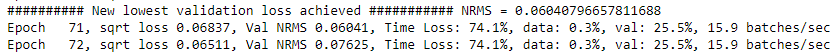

Here one can see a row, it states:

 * Epoch: current epoch
 * sqrt loss: the average of sqrt(loss) over the last epoch
 * Val NRMS: the NRMS simulation on the dataset given by `sim_val=val_enc`
 * Time Loss: X%, data: Y%, val Z% the time table of how much time is spend on each task.
    * Loss: propogating forward and backward
    * data: creating batches
    * val: validation process after each epoch. 
 * X batches/sec, the number of updates per second that are made. Generally in the range of 5 to 60 batches/sec

The validation loop is executed after each epoch (by default) and will be printed with the #############  ########## to screen if a new lowest validation is obtained. 

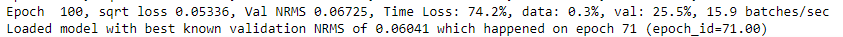

After the optimization is done or cut short the parameter values are loaded for which the lowest validation loss was obtained. This effectively is a version of early stopping using a validation set. 

If you want to view the last you can use

```python
fit_sys_ss_enc.checkpoint_load_system('_last')
```
and to load the one with the lowest validation loss use

```python
fit_sys_ss_enc.checkpoint_load_system('_best')
```

In [6]:
print(fit_sys_ss_enc.fn) #state network x_t+1 = f([x,u])
print(fit_sys_ss_enc.hn) #state network y_t = h(x_t)
print(fit_sys_ss_enc.encoder) #state network x_t = psi(upast, ypast)

simple_res_net(
  (net_lin): Linear(in_features=7, out_features=6, bias=True)
  (net_non_lin): feed_forward_nn(
    (net): Sequential(
      (0): Linear(in_features=7, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=6, bias=True)
    )
  )
)
simple_res_net(
  (net_lin): Linear(in_features=6, out_features=1, bias=True)
  (net_non_lin): feed_forward_nn(
    (net): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)
simple_res_net(
  (net_lin): Linear(in_features=6, out_features=6, bias=True)
  (net_non_lin): feed_forward_nn(
    (net): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, b

RMS simulation SS linear  0.36
RMS simulation IO linear  0.36
RMS simulation SS encoder 0.049
NRMS simulation SS linear  46.15%
NRMS simulation IO linear  46.36%
NRMS simulation SS encoder 6.26%


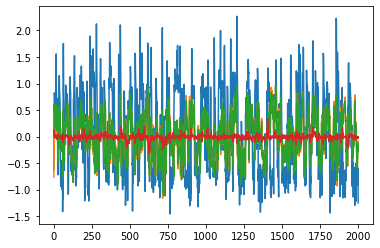

In [7]:
test_sim_enc = fit_sys_ss_enc.apply_experiment(test)

print(f'RMS simulation SS linear  {test_sim_SS.RMS(test):.2}') #equivilent to np.mean((test_sim_SS.y - test.y)**2)**0.5
print(f'RMS simulation IO linear  {test_sim_IO.RMS(test):.2}') #equivilent to np.mean((test_sim_IO.y[2:] - test.y[2:])**2)**0.5
print(f'RMS simulation SS encoder {test_sim_enc.RMS(test):.2}') #equivilent to np.mean((test_sim_enc.y[2:] - test.y[2:])**2)**0.5

print(f'NRMS simulation SS linear  {test_sim_SS.NRMS(test):.2%}') #equivilent to np.mean((test_sim_SS.y - test.y)**2)**0.5/np.std(test.y)
print(f'NRMS simulation IO linear  {test_sim_IO.NRMS(test):.2%}') #equivilent to np.mean((test_sim_IO.y[2:] - test.y[2:])**2)**0.5/np.std(test.y)
print(f'NRMS simulation SS encoder {test_sim_enc.NRMS(test):.2%}') #equivilent to np.mean((test_sim_enc.y[2:] - test.y[2:])**2)**0.5/np.std(test.y)

plt.plot(test.y)
plt.plot(test.y - test_sim_SS.y)
plt.plot(test.y - test_sim_IO.y)
plt.plot(test.y - test_sim_enc.y)
plt.show()

## 4.2 Futher Analysis


### 4.2.1 Loss curves




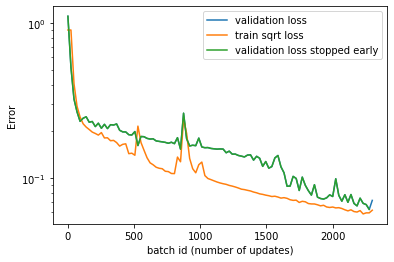

In [8]:

fit_sys_ss_enc.checkpoint_load_system('_last')

plt.semilogy(fit_sys_ss_enc.batch_id,fit_sys_ss_enc.Loss_val,label='validation loss')
plt.semilogy(fit_sys_ss_enc.batch_id,fit_sys_ss_enc.Loss_train**0.5,label='train sqrt loss')
plt.xlabel('batch id (number of updates)')
plt.ylabel('Error')

fit_sys_ss_enc.checkpoint_load_system('_best')
plt.semilogy(fit_sys_ss_enc.batch_id,fit_sys_ss_enc.Loss_val,label='validation loss stopped early')
plt.legend()
plt.show()

### 4.2.2 n-step errors

One of the best ways to analyise and develop is with the n-step-error defined as 

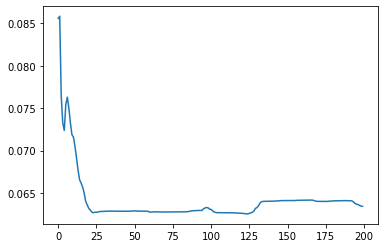

In [9]:
nsteperror = fit_sys_ss_enc.n_step_error(test,nf=200) #return in NRMS units of fit_sys_ss_enc.norm?
plt.plot(nsteperror)
plt.show()

### 4.2.3 view state variables

one might one to have insight into what $x_t$ is so one can use `save_state=True` on `apply_experiment`

(2000, 6)


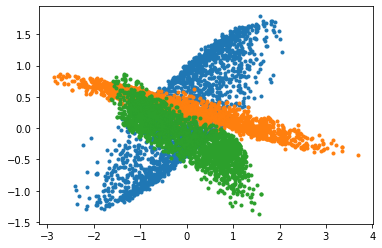

In [10]:
test_sim = fit_sys_ss_enc.apply_experiment(test,save_state=True)
X = test_sim.x #the System_data now has a .x attribute with shape (Ntime, nx)
print(X.shape)
plt.plot(X[:,0],X[:,1],'.')
plt.plot(X[:,2],X[:,3],'.')
plt.plot(X[:,4],X[:,5],'.')
plt.show()

## 4.3 Saving and loading systems results

all normal pickle rules apply

In [11]:
#save to file
# fit_sys_IO.save_system('IO-sys')
# fit_sys_SS.save_system('SS-sys')
# fit_sys_ss_enc.save_system('enc-sys')

#load from file
# fit_sys_IO = deepSI.load_system('IO-sys')
# fit_sys_SS = deepSI.load_system('IO-sys')
# fit_sys_ss_enc = deepSI.load_system('enc-sys')

## 4.4 Recovery of system after crash

Futhermore, after a crash you might want to recover the estimated system. 

It is quite a hack but the following process works

1. go to the check_point directory given by 

In [12]:
deepSI.datasets.get_work_dirs()['checkpoints']

'C:\\Users\\gerben\\AppData\\Local\\deepSI/checkpoints/'

2. Note down the id of last system (or the one you want to recover) saved (here it is 'iTOcsA')

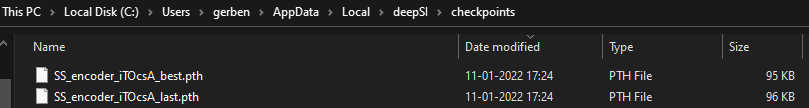

3. Recreate the system, set the unique code variable and load the last checkpoint as;

In [13]:
fit_sys_ss_enc = deepSI.fit_systems.SS_encoder(nx=6, na=3, nb=3)
fit_sys_ss_enc.unique_code = 'iTOcsA'
fit_sys_ss_enc.checkpoint_load_system('_best')

# fit_sys_ss_enc.save_system('') #save it normally